<h1>DCF77 PSK demodulation, "alternative ending" version </h1>

# Introduction

DCF77 is a timesignal transmitter located in Mainflingen near Frankfurt-am-Main in Germany. It transmits on 77.5 KHz with a transmission-power of 30 KW. <br>
<br>
The timesignal, as described on the website of the <a href="https://www.ptb.de/cms/en/ptb/fachabteilungen/abt4/fb-44/ag-442/dissemination-of-legal-time/dcf77.html">Physikalisch-Technische Bundesanstalt</a>, <a href="https://www.sigidwiki.com/wiki/DCF77">sigidwiki</a> and <a href="https://en.wikipedia.org/wiki/DCF77"> wikipedia</a> contains time information both in AM and in PSK. This notebook deals with decoding the PSK signal.<br>
The Phase-shift keying format of DCF77 is described in detail on the German-language version of the PTB website. Details can be found <a href="https://www.ptb.de/cms/de/ptb/fachabteilungen/abt4/fb-44/ag-442/dissemination-of-legal-time/dcf77/dcf77-phase-modulation.html">here</a> and <a href="https://www.ptb.de/cms/fileadmin/internet/fachabteilungen/abteilung_4/4.4_zeit_und_frequenz/pdf/2004_Piester_-_PTB-Mitteilungen_114.pdf">here</a>.<br>
<br>
In short, the PSK modulation of the timesignal is done by modulating the carrier with plus/minus 15.6 degrees phase-shift during the last 800 ms per second. This PSK modulation carries a fixed 512 bit pseudo-random bitsequence which is 0-to-1 inverted depending on the information bit that is sent.<br>
<br>
<b>This is an 'alternative ending' notebook. Everything up to part 3 ("correcting the phase slope") is identical to the dcf77psk notebook. From there on, an alternative way to determine the timesignal information bit is explained.</b>

# Part 1: Preparations
## Loading libraries

In [1]:
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt

from schmitt import schmitt


## Global variables

In [2]:
samp_rate=48000

pi=np.pi # short names
pi2=np.pi*2

## Load I/Q Data

In [3]:
fname="dcf77_30s.f32"

numsec=10 # just load l0 seconds
d=np.fromfile(fname,dtype=np.complex64,offset=0,count=int(samp_rate*numsec))


### Examining the data
Let's make a spectrogram (horizontal waterfall) of the signal<br>

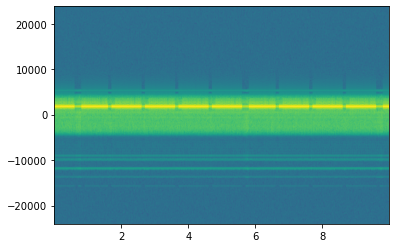

In [4]:

ax = plt.axes()
ax.specgram(d, Fs=48000, scale='dB')
plt.show()



## Frequency correction
We need to do a frequency correction. Let's first determine the frequency offset.<br>As the signal starts from the beginning of the sample-data, we can make a FFT of the very start of the signal and use that as a reference for the complete file.


In [5]:
numbins=2**18
f=np.fft.fftshift(np.fft.fft(d,n=numbins))

maxbin=np.argmax(f.real)

fr=samp_rate*(maxbin/numbins)-(samp_rate/2)
print("frequency:",fr)

frequency: 1800.29296875


### Downconvert to 0 Hz
Generare a tone of minus "frequency-correction" (see above) Hz, mix that with the received signal and plot the result

In [6]:
tone_freq=-fr
tone_t=np.linspace(0,numsec*tone_freq*2*np.pi,int(numsec*samp_rate), endpoint=False)
tone_s=np.cos(tone_t)+np.sin(tone_t)*1j

dmixed=d*tone_s

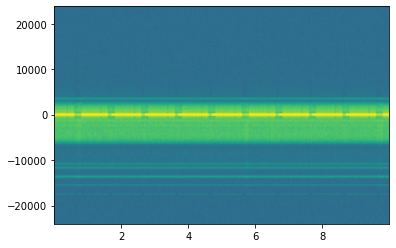

In [7]:
ax = plt.axes()
ax.specgram(dmixed, Fs=48000, scale='dB')
plt.show()

# Part 2: Analysing the signal
Let's take a look at the signal: the signal itself, and the amplitude, frequency and phase.<br>
We will zoom into the first 5 seconds of the data file.

In [8]:
# do AM, Phase and FM demodulation

amdemod=np.abs(dmixed)**2
ph=np.angle(dmixed)

fmdemod=np.diff(ph)
for i in np.where(fmdemod>pi)[0]: fmdemod[i] -= pi2

for i in np.where(fmdemod<-pi)[0]: fmdemod[i] += pi2

t=np.linspace(0,numsec,samp_rate*numsec) # timescale .. used for plotting

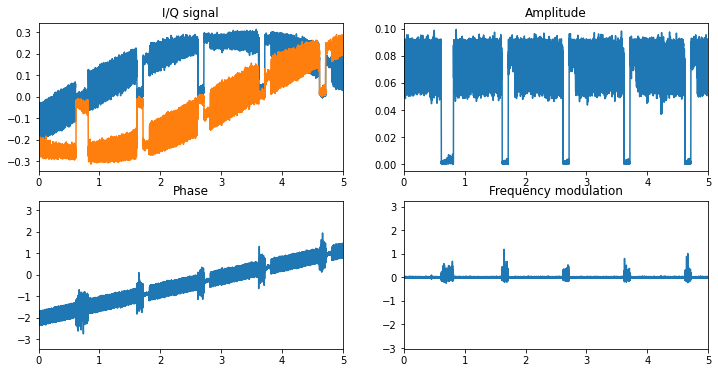

In [9]:
# create the plot

fig, axs = plt.subplots(2, 2)

# the signal itself
trgt=axs[0,0]
trgt.plot(t,dmixed.real)
trgt.plot(t,dmixed.imag)
trgt.set_title("I/Q signal")
trgt.set_xlim(0,5)

# amplitude
trgt=axs[0,1]
trgt.plot(t,amdemod)
trgt.set_title("Amplitude")
trgt.set_xlim(0,5)

# phase
trgt=axs[1,0]
trgt.plot(t,ph) # fm demodulation redunces the number of samples by 1
trgt.set_title("Phase")
trgt.set_xlim(0,5)

# frequency
trgt=axs[1,1]
trgt.plot(t[1:],fmdemod) # fm demodulation redunces the number of samples by 1
trgt.set_title("Frequency modulation")
trgt.set_xlim(0,5)


# figure size
fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

Some things to notice:
- In the amplitude graph, we clearly see the AM modulation on the time-sigan during the first 100 ms or 200 ms the second.
- In the phase graph, the signal is composed on the PSK modulated signal on top of a fixed upwards slope .
- When the amplitude of the signal is low, the phase and Frequency demodulated signal has a lot of noise. So it probably a good idea to do not run the PSK demodulation on the the complete packet, but only on the last 800 ms of the packet.

We will need to deal with the first two elements if we want to be able to demodulate the PSK signal. We will do this in the next steps.

# Part 3: cleaning up the AM signal
Although we do not use the AM modulation of the signal to decode the time-information, it is used to determine where the 1-second time-pulse begins.<br>
<br>
We will start with a schmitt-trigger threshhold detector to clean up the AM signal and plot the result.

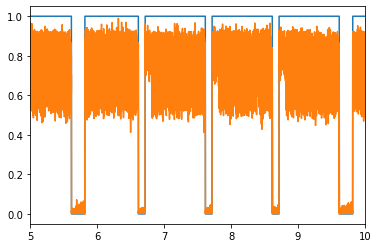

In [10]:
# apply schitt-trigger on the amplitude
st=schmitt(0.03, 0.05)

am_s=np.array([st.next(x) for x in amdemod])

plt.plot(t,am_s)
plt.plot(t,amdemod*10) # scale up for visibility

plt.xlim(5,10)
plt.show()


### Finding the start of a packet

We need to determine the start and end of of the modulated part of the time-pulse that contains the PSK information. That part is either 800 or 900 ms and starts when the AM-demodulated signal comes up.<br>
- If the timesignal information bit is '0', the carrier-amplitude is raised for 900 ms, including 100 ms block of unmodulated signal at the start
- If the timesignal information bit is '1', the carrier-amplitude is raised for only 800 ms

In [11]:
# detect changes in amplitude
edge=np.diff(am_s)
edgeup=np.where(edge == 1)[0]
edgedown=np.where(edge == -1)[0]

# the detector should start with an edge_up. If the first element of the detector output is a pulse-down, remove it from the list
if edgeup[0] > edgedown[0]: edgedown=edgedown[1:]

# the detector should end with an edge_dozn. If the last element of the detector output is a pulse-up, remove it from the list
if edgedown[-1] > edgedown[-1]: edgeup=edgeup[:-1]


packetboundaries=list(zip(edgeup,edgedown))

print(packetboundaries[:10]) # print up to the first 10 packets.

[(39145, 77525), (82349, 125525), (130344, 173524), (178344, 221524), (226339, 269525), (279142, 317524), (322338, 365526), (370341, 413524), (418343, 461525)]


## Inspecting the phase.

As we are interested in PSK, let's plot the phase of some of these packets. In this exercise, we'll look at packet number 0 and packet number 7.

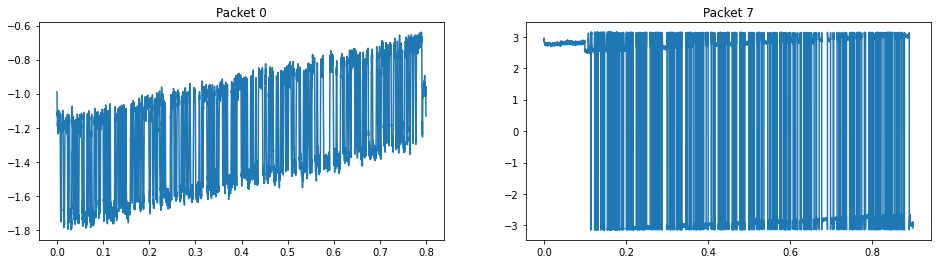

In [51]:
fig, axs = plt.subplots(1,2)

# plot phase of 1st packet
packetnumber=0

pstart,pend=packetboundaries[packetnumber]
l=pend-pstart # length
packet_t=np.linspace(0,l/samp_rate,l) # time axis
packet_ph=ph[pstart:pend]
axs[0].set_title("Packet 0")
axs[0].plot(packet_t,packet_ph)


# plot phase of 8th packet
packetnumber=7

pstart,pend=packetboundaries[packetnumber]
l=pend-pstart # length
packet_t=np.linspace(0,l/samp_rate,l) # time axis
packet_ph=ph[pstart:pend]
axs[1].set_title("Packet 7")
axs[1].plot(packet_t,packet_ph)

# figure size
fig.set_figwidth(16)
fig.set_figheight(4)

plt.show()


# Select a particular packet for the rest of the notebook

The signal contains multiple packets. Select below what packet to use for the rest of the notebook.

In [52]:
packetnumber=7

## Correcting the phase wrap-around

We will first continue with packet number 7. In that packet, we see the phase wrap-around +pi and -pi radient. We correct this by 'unwrapping' the phase.<br>
The rule in this exercise is that, if a phase if below 0, it is assumed to be above the '+pi' line, so 2*pi is added.

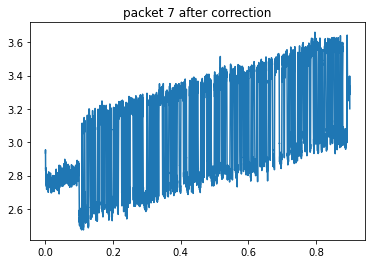

In [87]:
# plot phase of the packet .. without and with correction

pstart,pend=packetboundaries[packetnumber]
l=pend-pstart
packet_t=np.linspace(0,l/samp_rate,l)
packet_ph=ph[pstart:pend]
packet_phc=np.array([x if x > 0 else x + pi2 for x in packet_ph])
plt.plot(packet_t,packet_phc)
plt.title('packet 7 after correction')
plt.show()

## Some more cleanup: remove the unmodulated carrier (if present)

If a timesignal '0' is being transmitted, the carrier is AM modulated during 900 ms, but the first 100 ms does not carry any data.<br>
We will remove that part as it useless anyway and can only interfere with the FSK demodulator.

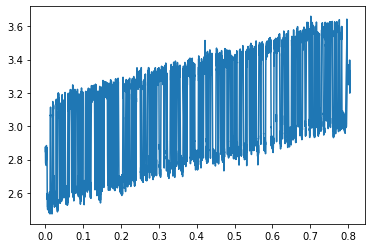

In [88]:
# strip 100 mt the beginning if the packet is a '0' databit.
if l > samp_rate * 0.85:
    packet_phc2=packet_phc[int(samp_rate*0.095):] # in fact, we remove just 95 ms; just to be safe.
    l=len(packet_phc2)
    packet_t=np.linspace(0,l/samp_rate,l)
else:
    packet_phc2=packet_phc

# plot the packet
plt.plot(packet_t,packet_phc2)
plt.show()


## Correcting the phase slope

Next step is to remove the constant slope. This is the result of a slight difference in frequency between the transmitter and the sender, even after applying the 'Downconvert to 0 Hz' step above.<br>
<br>
As the slope of the graph is lineair, we can determine the angle of the slope by measuring of the graph at two marker-points: one the beginning of the graph, the other near the end of the graph. We take the average of all the phase values 80 ms below and above every marker-point.<br>
Marker 1 is at 150 ms, marker 2 is at 700 ms.

In [55]:
m1=l*1.5/8 # marker 1
m2=l*7/8 # marker 2
msize=l*0.8/8
avg1=packet_phc2[int(m1-msize):int(m1+msize)].mean()
avg2=packet_phc2[int(m2-msize):int(m2+msize)].mean()
print(avg1,avg2)

2.916043941212127 3.26289970352753


### Le's do some math

We now have this system of lineair equations:<br>
$a + \frac{1.5}{8} b = avg1$<br>
$a + \frac{7}{8} b = avg2$<br>
<br>
To solve it, as we are using numpy anyway, we can use numpy.linalg.solve to find a and b.<br>
<br>We need to transform this system of equations into two matrices and feed that to the numpy lineair algabra solver.
$\begin{bmatrix} 1 & \frac{1.5}{8}   \\ 1 & \frac{7}{8} \end{bmatrix}$ and $\begin{bmatrix} avg1 \\ avg2 \end{bmatrix}$<br>
The solver function returns the following matrix:  $\begin{bmatrix} a \\ b \end{bmatrix}$

In [56]:
a=np.array([ [1,m1],[1,m2]])
b=np.array([avg1,avg2])
a1,a2=np.linalg.solve(a,b)

# print the solution of the system of lineair equation
print(a1,a2)


2.821446915126108 1.3062617416015532e-05


### To verify, recalculate the markerpoints

In [89]:
print(avg1,avg2)
print(a1+a2*m1,a1+a2*m2)

2.916043941212127 3.26289970352753
2.916043941212127 3.26289970352753


### Plot the packet and the slope
Then subtrack the slope from the packet; and plot again.

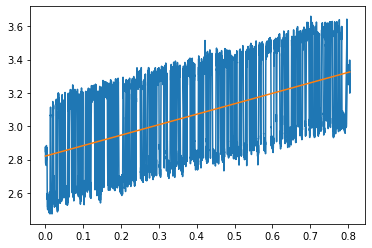

In [93]:
avgline=np.linspace(a1,a1+l*a2,l)

plt.plot(packet_t,packet_phc2)
plt.plot(packet_t,avgline)

plt.show()

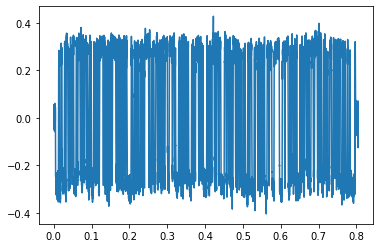

In [94]:
packet_phc3=packet_phc2-avgline
plt.plot(packet_t,packet_phc3)
plt.show()

# Part 4: Determining the PSK bitpattern polarity
The goal of this part of the notebook is to determine the timesignal information bit. DCF77 transmits a fixed predefined PSK bitpattern which can be inverted or not.<br>
The received bitpattern is compaired with the predefined PSK bitpattern using correlation. If the received pattern is not inverted, the correlation returns a positive value. Am inverted bitpattern results in a negative value correlation.

## Downsample 

To reduce the amount of data to process, let's first downsample the signal to 16 ksps and plot it. It should be visualy identical to the 48 Ksps signal.

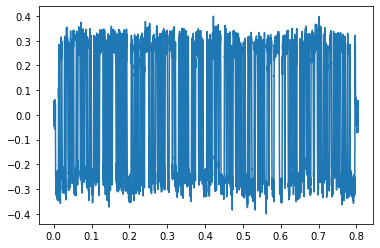

In [60]:
decim=3 # 48k to 16 k
packet16k=scipy.signal.resample_poly(packet_phc3,1,decim)
l=len(packet16k)

samp_rate_2=int(samp_rate/decim)
packet_t16k=np.linspace(0,l/samp_rate_2,l)

plt.plot(packet_t16k,packet16k)
plt.show()

## Create the DCF77 PSK bitpattern
The PSK-modulated signal is a fixed predefined pseudo-random bitpattern, as defined by the specification found in the reference documents. Create the bitpattern, print it and plot it.

In [61]:
pskbits=[]

lfsr = 0

for _ in range(512):
        chip = lfsr & 1
        pskbits.append(1 if chip > 0 else -1)
        lfsr >>= 1
        if (chip > 0 ) or (lfsr == 0): lfsr ^= 0x110
#end for

pskbits=np.array(pskbits)

In [62]:
print(pskbits)

[-1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1  1
 -1  1 -1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1 -1  1  1
 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1
  1 -1 -1  1  1  1  1  1  1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1  1  1
 -1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1
  1  1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1  1 -1  1  1 -1 -1  1  1  1  1 -1
 -1 -1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1 -1  1
  1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1
 -1  1 -1  1  1  1  1 -1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1  1  1
  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1

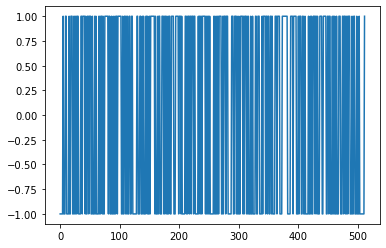

In [63]:
plt.plot(pskbits)
plt.show()

## Upsample the PSK bitpattern

The PSK bitpattern is just a 512 bit bitpattern. If we want to be able to compair it with the received signal, we should upsample it to the same sample-rate.<br>
<br>
DCF77 transmit 512 bits of PSK data in 793 ms. At 16000 samples/second, that is 12688 samples in total. Let's use numpy to find the best ratio to go from 512 bits to 12688 samples.

In [96]:
lcm=np.lcm(512,12688)
mult=lcm//512
div=lcm//12688
print()
print("The least common multiple is",lcm)
print("To go from 512 to 12688, first multiply by",mult,"and then divide by",div)


The least common multiple is 406016
To go from 512 to 12688, first multiply by 793 and then divide by 32


### Now upsample the PSK bitpattern.

In [66]:
pskbits_16ksps=scipy.signal.resample_poly(pskbits,mult,div)
packet_t16k
pcktl=len(pskbits_16ksps)


## Visual check
Plot both the received signal and psk bitstream, and zoom in.

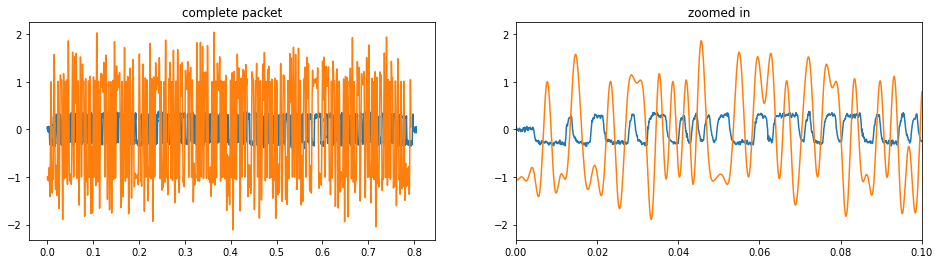

In [97]:

fig, axs = plt.subplots(1,2)

# complete packet + zoom in
axs[0].plot(packet_t16k,packet16k)
axs[0].plot(packet_t16k[:pcktl],pskbits_16ksps)
axs[0].set_title("complete packet")

axs[1].plot(packet_t16k,packet16k)
axs[1].plot(packet_t16k[:pcktl],pskbits_16ksps)
axs[1].set_title("zoomed in")
axs[1].set_xlim(0,0.1)

# figure size
fig.set_figwidth(16)
fig.set_figheight(4)

plt.show()




You should see that in the zoomed-in plot that the received packet and the PSK bitpattern have a simular trend, with two notes:
- The two graphs can have an opposite polarity ... that's the goal of this notebook, remember? :-)
- The two graphs can have be shifted relative to eachother.

To be able to better visualise this, let shift the timescale of the PSKbits a little bit. By how much the plot needs to be shifted differs per packet. For packet number 7, the shift is - 5.5 ms.

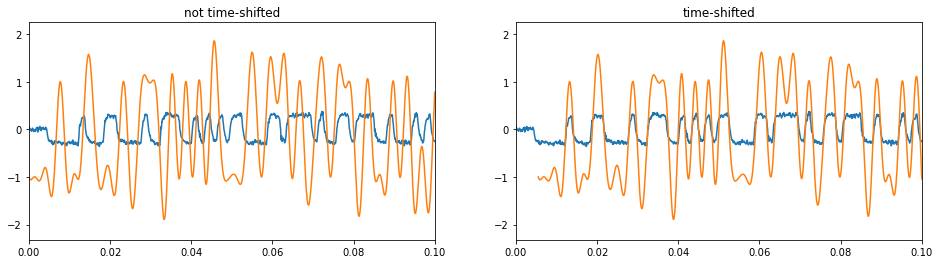

In [99]:
pskshift = -0.0055 # in seconds

fig, axs = plt.subplots(1,2)

# complete packet + zoom in
axs[0].plot(packet_t16k,packet16k)
axs[0].plot(packet_t16k[:pcktl],pskbits_16ksps)
axs[0].set_title("not time-shifted")
axs[0].set_xlim(0,0.1)

axs[1].plot(packet_t16k,packet16k)
axs[1].plot(packet_t16k[:pcktl]-pskshift,pskbits_16ksps)
axs[1].set_title("time-shifted")
axs[1].set_xlim(0,0.1)

# figure size
fig.set_figwidth(16)
fig.set_figheight(4)

plt.show()




## Let's correlate the expected signal (the pskbit pattern) with the received signal.
If the correlation has a clear positive peak, then the received signal has the same polarity as the predefined PSK bitpattern.<br>
If the correlation has a clear negative peak, then the received signal has the opposite polarity as te predefined PSK bitpattern.<br>
<br>
### Correlation over the complete PSK bitpattern.
Plot and analyse.

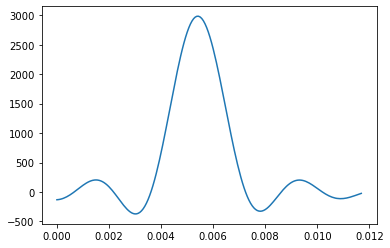

In [103]:
cor=np.correlate(packet16k, pskbits_16ksps)

corlen=len(cor)

plt.plot(packet_t16k[:corlen],cor)

plt.show()

In [105]:
maxvalpos=np.argmax(cor)
print()
print("the correlation maximum is","positive" if cor[maxvalpos] > 0 else "negative")


the correlation maximum is positive


### Correction of parts of the PSK bitpattern.

An alternative is to correlate the received signal with only part of the bitpattern. This has the advantage that if received signal only partially received, it should be possible to still detect a "partial hit".<br>
<br>
In this example, we will check the correlation between the received signal and eight time 1/8 of the PSK bitpattern.

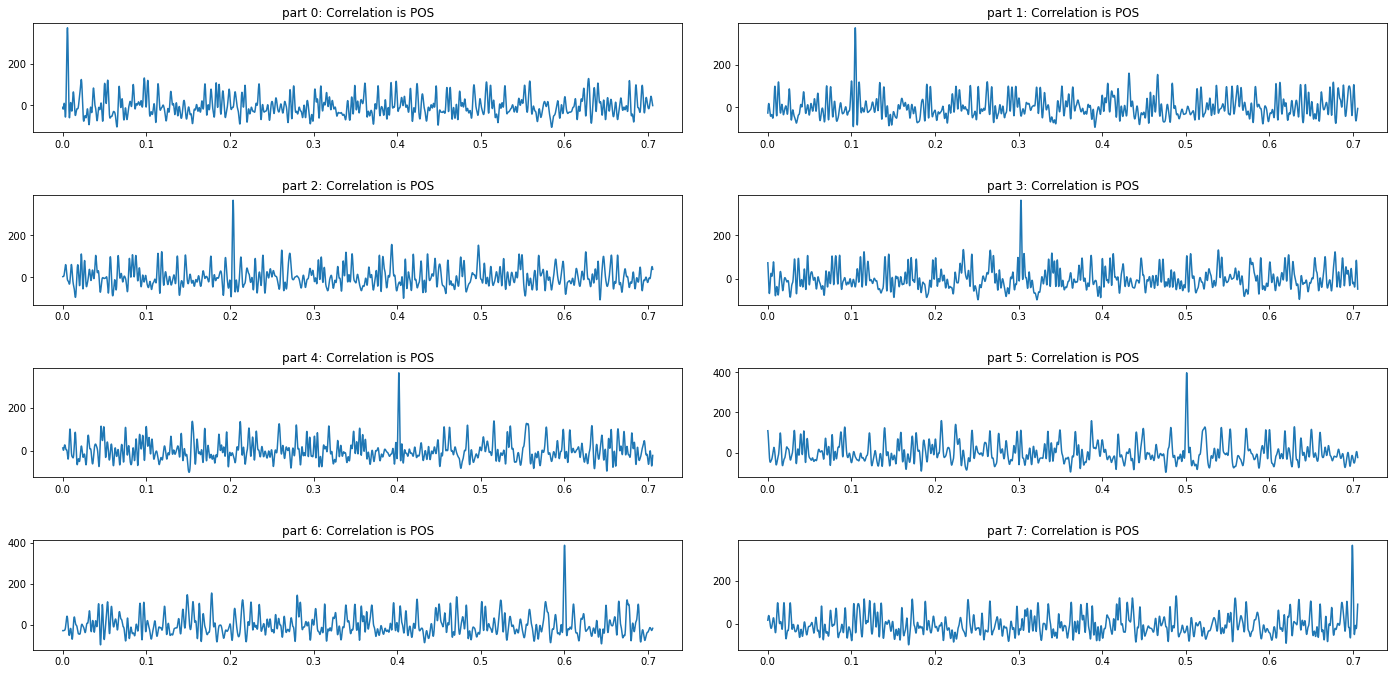

In [106]:
pckl8=pcktl//8

fig, axs = plt.subplots(4,2)

for i in range(8):
    ply=i//2
    plx=i%2
    
    pskbits_16ksps_sub=pskbits_16ksps[pckl8 * i : pckl8 * (i+1)]
    corsub=np.correlate(packet16k, pskbits_16ksps_sub)
    
    # find peak in the correlation
    maxvalpos=np.argmax(corsub)
    maxvaltxt=" POS" if corsub[maxvalpos] > 0 else " NEG"
    
    subcorlen=len(corsub)
    
    #axs[ply,plx].plot(packet_t16k,corsub)
    axs[ply,plx].plot(packet_t16k[:subcorlen],corsub)
    axs[ply,plx].set_title("part "+str(i)+": Correlation is"+maxvaltxt)
#end for

# figure size
fig.set_figwidth(20)
fig.set_figheight(10)

fig.tight_layout(pad=3.0)

plt.show()


# Done!

Or go back to the cell "Select a particular packet for the rest of the notebook" and select a different packet to analyse.